In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.div import CORDIV_kernel
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

--- 0.3900001049041748 seconds ---
dividend error:  tensor(-0.0058, device='cuda:0') tensor(0.0020, device='cuda:0')
divisor  error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
quotient error:  tensor(-0.5000, device='cuda:0') tensor(0.4961, device='cuda:0')
RMSE 0.048069989358778986
MAE 0.026657812
bias -0.0072132815


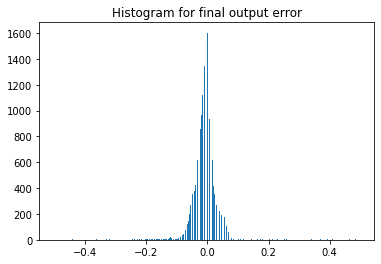

In [4]:
col = 10000
modes = ["unipolar"]
static = True
bitwidth = 8
bstype = torch.float
randtype = torch.float

for mode in modes:
    if mode is "unipolar":
        quotient = torch.rand(2, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        divisor = torch.rand(2, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        quotient = torch.rand(2, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
        divisor = torch.rand(2, col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_div = CORDIV_kernel(buf_dep=4, rng="Sobol", rng_dim=1, bstype=torch.float).to(device)

    dividend = torch.mul(quotient, divisor).to(device)

    quotientPE = ProgressiveError(quotient, mode=mode).to(device)

    dividendPE = ProgressiveError(dividend, mode=mode).to(device)
    dividendSRC = SourceGen(dividend, bitwidth, mode=mode, randtype=randtype)().to(device)
    dividendRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    dividendBS = BSGen(dividendSRC, dividendRNG, bstype).to(device)
    
    divisorPE  = ProgressiveError(divisor,  mode=mode).to(device)
    divisorSRC = SourceGen(divisor, bitwidth, mode=mode, randtype=randtype)().to(device)
    divisorRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    divisorBS = BSGen(divisorSRC, divisorRNG, bstype).to(device)

    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            dividend_bs = dividendBS(torch.tensor([i]))
            dividendPE.Monitor(dividend_bs)

            divisor_bs = divisorBS(torch.tensor([i]))
            divisorPE.Monitor(divisor_bs)
            
            quotient_bs = dut_div(dividend_bs, divisor_bs)   
            quotientPE.Monitor(quotient_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("dividend error: ", torch.min(dividendPE()[1]), torch.max(dividendPE()[1]))
        print("divisor  error: ", torch.min(divisorPE()[1]), torch.max(divisorPE()[1]))
        
        print("quotient error: ", torch.min(quotientPE()[1]), torch.max(quotientPE()[1]))
        
        result_pe = quotientPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("MAE", np.mean(np.abs(result_pe)))
        print("bias", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()